<a href="https://colab.research.google.com/github/mnijhuis-dnb/Artificial_Intelligence_and_Machine_Learning_for_SupTech/blob/main/Tutorials/Tutorial%205%20Decision%20trees%20and%20random%20forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Artificial Intelligence and Machine Learning for SupTech  
Tutorial 5: Decision trees and random forests

*	Growing your own decision tree
*	How deep? How many splits? How big are the leaves?
*	From trees to random forests
*	Comparing performance with the confusion matrix

<br/>

14 March 2023  

**Instructors**  
Prof. Iman van Lelyveld (iman.van.lelyveld@vu.nl)<br/>
Dr. Michiel Nijhuis (m.nijhuis@dnb.nl)  

In [ ]:
!wget -O bdp2022-material.zip https://dieter.wang/files/bdp2022-material-day2.zip
!unzip -o bdp2022-material.zip

--2022-09-20 15:01:57--  https://dieter.wang/files/bdp2022-material-day2.zip
Resolving dieter.wang (dieter.wang)... 85.13.135.217
Connecting to dieter.wang (dieter.wang)|85.13.135.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16411449 (16M) [application/zip]
Saving to: ‘bdp2022-material.zip’

bdp2022-material.zi 100%[===================>]  15.65M  45.5MB/s    in 0.3s    

2022-09-20 15:01:57 (45.5 MB/s) - ‘bdp2022-material.zip’ saved [16411449/16411449]

Archive:  bdp2022-material.zip
  inflating: 10_Industry_Portfolios.csv  
  inflating: 25_Portfolios_5x5.csv   
  inflating: company.csv             
  inflating: F-F_Momentum_Factor.csv  
  inflating: F-F_Research_Data_5_Factors_2x3.csv  
  inflating: returns.csv             


Tooday is about applying machine learning methods to examine stock returns in various ways. This involves data processing, standardization, normalization, model fitting etc. Importantly, we

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Stock return data
`returns.csv` contains `df_returns`
Column 1 (`permno`) is the unique company identifier.
Column 2 (`date`) is the unique date identifier.
Column 3 (`RET`) is the Holding Period Return
We will refer to these as $r_{it}$ 
The main question you need to answer is: Which companies do you use? Several factors will determine your decision.

In [ ]:
path = 'returns.csv'
df_returns = pd.read_csv(path)

In [ ]:
df_returns

,permno,date,RET
0,10080,2000-01-31,0.583333
1,10080,2000-02-29,-0.315789
2,10080,2000-03-31,-0.076923
3,10080,2000-04-28,0.125000
4,10080,2000-05-31,-0.018519
...,...,...,...
60402,86739,2009-03-31,0.010590
60403,86739,2009-04-30,0.236527
60404,86739,2009-05-29,0.566586
60405,86739,2009-06-30,0.016229


In [ ]:
len(df_returns['permno'].unique())

682

In [ ]:
df_returns.head(5)

,permno,date,RET
0,10080,2000-01-31,0.583333
1,10080,2000-02-29,-0.315789
2,10080,2000-03-31,-0.076923
3,10080,2000-04-28,0.125000
4,10080,2000-05-31,-0.018519


In [ ]:
df_returns.dtypes

permno     int64
date      object
RET       object
dtype: object

Interestingly, `RET` is stored as object. This is problematic, since we need numeric values. Can you think of a reason why this column is loaded as string?
. <br/>
. <br/>
. <br/>
. <br/>
. <br/>
. <br/>
. <br/>

In [ ]:
df_returns['RET'].describe()

count     60407
unique    46788
top           .
freq       1740
Name: RET, dtype: object

Evidently, the most common value `top` is a dot `.`. This is a marker for missing values. In python we use `np.nan` do designate a missing value, which is a numerical data type.

In [ ]:
df_returns['RET'] = df_returns['RET'].replace('.', np.nan)
df_returns['RET'] = df_returns['RET'].astype(float)

In [ ]:
df_returns['RET'].describe()

count    58667.000000
mean         0.009655
std          0.166696
min         -0.935356
25%         -0.054363
50%          0.005153
75%          0.061492
max          5.640000
Name: RET, dtype: float64

Note that the `date` column is an object. It is stored as a string. However, we may be interested in the date itself, i.e. the month or the year, such that we can compute monthly averages, changes over time, etc.


In [ ]:
df_returns['date'].head()

0    2000-01-31
1    2000-02-29
2    2000-03-31
3    2000-04-28
4    2000-05-31
Name: date, dtype: object

In [ ]:
df_returns['date'] = pd.to_datetime(df_returns['date'], format="%Y-%m-%d")
df_returns['date'].head()

0   2000-01-31
1   2000-02-29
2   2000-03-31
3   2000-04-28
4   2000-05-31
Name: date, dtype: datetime64[ns]

In [ ]:
df_returns['date'].dt.hour

0        0
1        0
2        0
3        0
4        0
        ..
60402    0
60403    0
60404    0
60405    0
60406    0
Name: date, Length: 60407, dtype: int64

Now, let's tell python that this is a DataFrame that contains **panel** data, i.e. it has both an entity and date identifier. 

In Stata, this would be similar to `xtset`

In [ ]:
df_returns = df_returns.set_index(['permno','date'])

In [ ]:
df_returns.tail(30)

RET
permno date                
86739  2007-02-28 -0.004464
       2007-03-30  0.040919
       2007-04-30 -0.002692
       2007-05-31  0.004860
       2007-06-29  0.029554
       2007-07-31  0.098121
       2007-08-31 -0.072719
       2007-09-28  0.028703
       2007-10-31 -0.141006
       2007-11-30 -0.107889
       2007-12-31 -0.050065
       2008-01-31 -0.036961
       2008-02-29 -0.100924
       2008-03-31  0.044269
       2008-04-30 -0.125662
       2008-05-30  0.121212
       2008-06-30 -0.073359
       2008-07-31 -0.061667
       2008-08-29  0.210480
       2008-09-30 -0.212032
       2008-10-31 -0.243948
       2008-11-28  0.071429
       2008-12-31  0.081609
       2009-01-30 -0.259299
       2009-02-27 -0.051650
       2009-03-31  0.010590
       2009-04-30  0.236527
       2009-05-29  0.566586
       2009-06-30  0.016229
       2009-07-31       NaN

Doing so allows us to select and aggregate relevant subsets. For example, we want to plot the return series of company with id `11018`

In [ ]:
sr_11018 = df_returns.loc[11018,'RET']
sr_11018.head()

date
2000-01-31   -0.126506
2000-02-29   -0.062069
2000-03-31    0.043235
2000-04-28    0.003546
2000-05-31    0.024735
Name: RET, dtype: float64

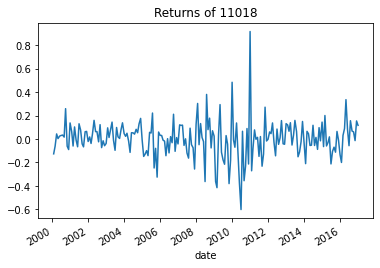

In [ ]:
sr_11018.plot(title='Returns of 11018');

What if we want to know the 1-year average return?

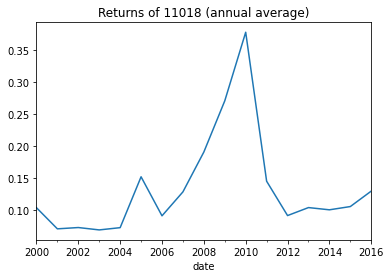

In [ ]:
sr_11018_avg = sr_11018.resample('Y').std()
sr_11018_avg.plot(title='Returns of 11018 (annual average)');

What if we want to know the 1-year moving average?

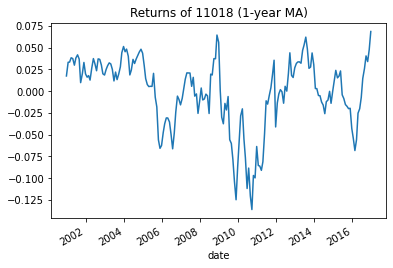

In [ ]:
sr_11018_ma = sr_11018.rolling(12).mean()
sr_11018_ma.plot(title='Returns of 11018 (1-year MA)');

Or the 3-month rolling standard deviation?

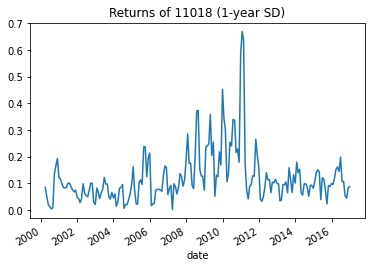

In [ ]:
sr_11018_sd = sr_11018.rolling(3).std()
sr_11018_sd.plot(title='Returns of 11018 (1-year SD)');

## Firm characteristics

`characteristics.csv` contains `df_features` Column 1 (`permno`) is the unique company identifier.
Column 2 (`date`) is the unique date identifier.
Column 3-96 are the 94 lagged firm characteristics.
We will refer to these as $X_{it}$. For more information, have a look at Green, Hand, Zhang (2017), in the literature folder.


In [ ]:
path = 'company.csv'
df_features = pd.read_csv(path)

df_features['date'] = pd.to_datetime(df_features['date'])
df_features = df_features.set_index(['permno','date'])

In [ ]:
df_features.dtypes

mvel1         float64
beta          float64
betasq        float64
chmom         float64
dolvol        float64
               ...   
maxret        float64
retvol        float64
std_dolvol    float64
std_turn      float64
zerotrade     float64
Length: 93, dtype: object

In [ ]:
df_features.describe().T

,count,mean,std,min,25%,50%,75%,max
mvel1,86682.0,2.311203e+06,7.384763e+06,2.860000e+02,7.185872e+04,2.723435e+05,1.178604e+06,1.221146e+08
beta,80440.0,1.009542e+00,6.870623e-01,-1.933279e+00,5.069216e-01,9.236055e-01,1.379090e+00,3.987207e+00
betasq,80440.0,1.494624e+00,1.932250e+00,2.267937e-11,2.597442e-01,8.549868e-01,1.906975e+00,1.589782e+01
chmom,81438.0,-5.954614e-05,5.743313e-01,-9.062534e+00,-2.229188e-01,-8.020340e-03,2.112902e-01,8.083012e+00
dolvol,86039.0,1.240541e+01,2.773605e+00,-2.876821e-01,1.046905e+01,1.239194e+01,1.447285e+01,1.900568e+01
...,...,...,...,...,...,...,...,...
maxret,86699.0,6.860511e-02,7.318905e-02,1.999982e-03,2.615409e-02,4.577707e-02,8.256873e-02,9.444444e-01
retvol,86657.0,3.027789e-02,2.590054e-02,0.000000e+00,1.360564e-02,2.264192e-02,3.802162e-02,2.800543e-01
std_dolvol,86606.0,7.083646e-01,3.903126e-01,0.000000e+00,4.226663e-01,5.860744e-01,9.008867e-01,2.786869e+00
std_turn,86682.0,6.019685e+00,1.406746e+01,0.000000e+00,1.171293e+00,2.479289e+00,5.504330e+00,4.211951e+02


In [ ]:
df_features.head()

mvel1      beta    betasq     chmom    dolvol   idiovol  \
permno date                                                                   
10080  2000-01-31  2868.0 -0.073811  0.020791 -0.097727  3.065142  0.068324   
       2000-02-29  4541.0 -0.081841  0.017610  0.483402  6.348264  0.068271   
       2000-03-31  3107.0  0.104741  0.010971 -0.018970  8.959376  0.076380   
       2000-04-28  2868.0  0.012597  0.000159 -0.108316  7.116191  0.080496   
       2000-05-31  3226.5  0.162976  0.026561  0.140756  8.779481  0.137188   

                     indmom     mom1m     mom6m    mom12m  ...    stdacc  \
permno date                                                ...             
10080  2000-01-31 -0.097056 -0.020408 -0.257576 -0.387500  ...       NaN   
       2000-02-29  0.002209  0.583333 -0.213115 -0.400000  ...       NaN   
       2000-03-31  0.147039 -0.315789  0.245902  0.085714  ...       NaN   
       2000-04-28  0.310041 -0.076923 -0.118644 -0.187500  ...       NaN   
       2000-05-31  0.249398  0.125000 -0.142857 -0.294118  ...  0.073539   

                      stdcf   ms  baspread       ill    maxret    retvol  \
permno date                                                                
10080  2000-01-31       NaN  NaN  0.051729  0.000017  0.136364  0.042418   
       2000-02-29       NaN  NaN  0.181881  0.000014  0.444444  0.127924   
       2000-03-31       NaN  NaN  0.106763  0.000024  0.217391  0.095731   
       2000-04-28       NaN  NaN  0.193484  0.000025  0.600000  0.170228   
       2000-05-31  0.075737  2.0  0.116561  0.000019  0.230769  0.109373   

                   std_dolvol   std_turn     zerotrade  
permno date                                             
10080  2000-01-31    1.382123   2.053254  1.336364e+01  
       2000-02-29    1.801642  24.497492  8.400000e+00  
       2000-03-31    1.007548   2.234800  3.150000e+00  
       2000-04-28    1.714707  24.415433  9.130435e-01  
       2000-05-31    1.121564   7.291179  2.926231e-08  

[5 rows x 93 columns]

## Missing values

## Over time

In [ ]:
df_returns.notna()

RET
permno date             
10080  2000-01-31   True
       2000-02-29   True
       2000-03-31   True
       2000-04-28   True
       2000-05-31   True
...                  ...
86739  2009-03-31   True
       2009-04-30   True
       2009-05-29   True
       2009-06-30   True
       2009-07-31  False

[60407 rows x 1 columns]

In [ ]:
df_returns.notna().groupby('date').mean()

,RET
date,
2000-01-31,0.974409
2000-02-29,0.962302
2000-03-31,0.965657
2000-04-28,0.977413
2000-05-31,0.977366
...,...
2016-08-31,0.986532
2016-09-30,0.976431
2016-10-31,0.989831


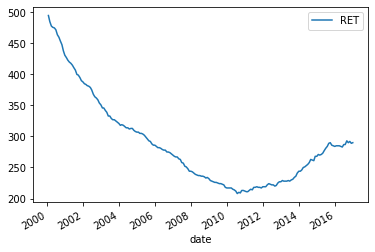

In [ ]:
df_returns.notna().groupby('date').sum().plot()

## Fill missing values for companies

### Returns
After having a look at how severe the problem is, we decide to fill in those missing with the value `0`. In other words, we assume that the companies did not have any stock appreciation or depreciation in that month.

In [ ]:
sr_nb_missing = df_returns.notna().groupby('permno').sum()

In [ ]:
sr_nb_missing.value_counts().sort_values()

RET
145      1
148      1
96       1
150      1
186      1
      ... 
17      11
1       11
7       12
30      13
204    143
Length: 157, dtype: int64

In [ ]:
df_returns = df_returns.fillna(0)

### Firm characteristics
In this case, for each characteristic we fill in the `median` over all companies.

In [ ]:
df_features

mvel1      beta    betasq     chmom     dolvol  \
permno date                                                                
10080  2000-01-31   2868.000000 -0.073811  0.020791 -0.097727   3.065142   
       2000-02-29   4541.000000 -0.081841  0.017610  0.483402   6.348264   
       2000-03-31   3107.000000  0.104741  0.010971 -0.018970   8.959376   
       2000-04-28   2868.000000  0.012597  0.000159 -0.108316   7.116191   
       2000-05-31   3226.500000  0.162976  0.026561  0.140756   8.779481   
...                         ...       ...       ...       ...        ...   
93434  2016-08-31  81722.189349  0.613588  0.376491  0.230830  10.311459   
       2016-09-30  81892.803254  0.640843  0.410680  0.307585  10.417335   
       2016-10-31  89086.798334  0.621815  0.386653  0.311400  10.559307   
       2016-11-30  89289.053372  0.611079  0.373417  0.100218  10.691081   
       2016-12-30  85732.803407  0.628519  0.395036  0.020854  10.862196   

                    idiovol    indmom     mom1m     mom6m    mom12m  ...  \
permno date                                                          ...   
10080  2000-01-31  0.068324 -0.097056 -0.020408 -0.257576 -0.387500  ...   
       2000-02-29  0.068271  0.002209  0.583333 -0.213115 -0.400000  ...   
       2000-03-31  0.076380  0.147039 -0.315789  0.245902  0.085714  ...   
       2000-04-28  0.080496  0.310041 -0.076923 -0.118644 -0.187500  ...   
       2000-05-31  0.137188  0.249398  0.125000 -0.142857 -0.294118  ...   
...                     ...       ...       ...       ...       ...  ...   
93434  2016-08-31  0.063863 -0.098645  0.098624  0.053140 -0.024608  ...   
       2016-09-30  0.063298 -0.032050  0.002088  0.143198 -0.042000  ...   
       2016-10-31  0.063176  0.021838  0.062500  0.148325  0.043478  ...   
       2016-11-30  0.060052  0.029155 -0.009804  0.111111  0.111111  ...   
       2016-12-30  0.059797  0.015187 -0.049505  0.109890  0.147727  ...   

                     stdacc     stdcf   ms  baspread           ill    maxret  \
permno date                                                                    
10080  2000-01-31       NaN       NaN  NaN  0.051729  1.694670e-05  0.136364   
       2000-02-29       NaN       NaN  NaN  0.181881  1.433350e-05  0.444444   
       2000-03-31       NaN       NaN  NaN  0.106763  2.414690e-05  0.217391   
       2000-04-28       NaN       NaN  NaN  0.193484  2.485920e-05  0.600000   
       2000-05-31  0.073539  0.075737  2.0  0.116561  1.876960e-05  0.230769   
...                     ...       ...  ...       ...           ...       ...   
93434  2016-08-31  0.744023  0.860093  3.0  0.034544  2.078034e-07  0.050439   
       2016-09-30  0.744023  0.860093  3.0  0.033108  1.353902e-07  0.057105   
       2016-10-31  0.744023  0.860093  3.0  0.028333  8.153614e-08  0.027542   
       2016-11-30  0.746650  0.860708  3.0  0.026600  1.237021e-07  0.023857   
       2016-12-30  0.746650  0.860708  3.0  0.042877  8.576942e-08  0.031579   

                     retvol  std_dolvol   std_turn     zerotrade  
permno date                                                       
10080  2000-01-31  0.042418    1.382123   2.053254  1.336364e+01  
       2000-02-29  0.127924    1.801642  24.497492  8.400000e+00  
       2000-03-31  0.095731    1.007548   2.234800  3.150000e+00  
       2000-04-28  0.170228    1.714707  24.415433  9.130435e-01  
       2000-05-31  0.109373    1.121564   7.291179  2.926231e-08  
...                     ...         ...        ...           ...  
93434  2016-08-31  0.024276    0.907406   1.873059  5.346671e-08  
       2016-09-30  0.020000    0.791762   1.556431  4.042364e-08  
       2016-10-31  0.014948    0.859552   1.892951  4.147196e-08  
       2016-11-30  0.016641    0.988161   2.634311  3.531392e-08  
       2016-12-30  0.019838    0.629682   2.431419  3.518593e-08  

[86702 rows x 93 columns]

In [ ]:
df_features.dropna(axis=0).shape

(7659, 93)

In [ ]:
df_features.dropna(axis=1).shape

(86702, 0)

In [ ]:
df_features.dropna(how='all', axis=0).shape

(86702, 93)

In [ ]:
sr_medians = df_features.median()
sr_medians.head()

mvel1     272343.477425
beta           0.923606
betasq         0.854987
chmom         -0.008020
dolvol        12.391936
dtype: float64

In [ ]:
df_features = df_features.fillna(sr_medians)

In [ ]:
df_features.notna().mean().mean()

1.0

### Ensure that returns and characteristics cover the same firms and periods

In [ ]:
df_returns.index.shape

(60407,)

In [ ]:
df_features.index.shape

(86702,)

In [ ]:
df_returns.index

MultiIndex([(10080, '2000-01-31'),
            (10080, '2000-02-29'),
            (10080, '2000-03-31'),
            (10080, '2000-04-28'),
            (10080, '2000-05-31'),
            (10080, '2000-06-30'),
            (10080, '2000-07-31'),
            (10080, '2000-08-31'),
            (10080, '2000-09-29'),
            (10080, '2000-10-31'),
            ...
            (86739, '2008-10-31'),
            (86739, '2008-11-28'),
            (86739, '2008-12-31'),
            (86739, '2009-01-30'),
            (86739, '2009-02-27'),
            (86739, '2009-03-31'),
            (86739, '2009-04-30'),
            (86739, '2009-05-29'),
            (86739, '2009-06-30'),
            (86739, '2009-07-31')],
           names=['permno', 'date'], length=60407)

In [ ]:
df_features.index

MultiIndex([(10080, '2000-01-31'),
            (10080, '2000-02-29'),
            (10080, '2000-03-31'),
            (10080, '2000-04-28'),
            (10080, '2000-05-31'),
            (10080, '2000-06-30'),
            (10080, '2000-07-31'),
            (10080, '2000-08-31'),
            (10080, '2000-09-29'),
            (10080, '2000-10-31'),
            ...
            (93434, '2016-03-31'),
            (93434, '2016-04-29'),
            (93434, '2016-05-31'),
            (93434, '2016-06-30'),
            (93434, '2016-07-29'),
            (93434, '2016-08-31'),
            (93434, '2016-09-30'),
            (93434, '2016-10-31'),
            (93434, '2016-11-30'),
            (93434, '2016-12-30')],
           names=['permno', 'date'], length=86702)

In [ ]:
common_index = df_returns.index.intersection(df_features.index)
common_index

MultiIndex([(10080, '2000-01-31'),
            (10080, '2000-02-29'),
            (10080, '2000-03-31'),
            (10080, '2000-04-28'),
            (10080, '2000-05-31'),
            (10080, '2000-06-30'),
            (10080, '2000-07-31'),
            (10080, '2000-08-31'),
            (10080, '2000-09-29'),
            (10080, '2000-10-31'),
            ...
            (86739, '2008-10-31'),
            (86739, '2008-11-28'),
            (86739, '2008-12-31'),
            (86739, '2009-01-30'),
            (86739, '2009-02-27'),
            (86739, '2009-03-31'),
            (86739, '2009-04-30'),
            (86739, '2009-05-29'),
            (86739, '2009-06-30'),
            (86739, '2009-07-31')],
           names=['permno', 'date'], length=58487)

In [ ]:
common_index.shape

(58487,)

In [ ]:
df_returns = df_returns.loc[common_index]
df_features = df_features.loc[common_index]

# What characteristics explain stock returns?

What determines the differences between average stock returns? This perspective implies that we do not care much about the time-variation. If this were a linear regression model, you would estimate

$$
r_i = X_i\beta + e_i
$$

where $r_i$ is the average return over the entire observation sample. Similarly, $X_i$ is the average characteristic of firm $i$.

In [ ]:
import statsmodels.api as sm

In [ ]:
df_returns

RET
permno date                
10080  2000-01-31  0.583333
       2000-02-29 -0.315789
       2000-03-31 -0.076923
       2000-04-28  0.125000
       2000-05-31 -0.018519
...                     ...
86739  2009-03-31  0.010590
       2009-04-30  0.236527
       2009-05-29  0.566586
       2009-06-30  0.016229
       2009-07-31  0.000000

[58487 rows x 1 columns]

In [ ]:
sr_targets = df_returns.groupby('permno').mean()
sr_targets.head()

,RET
permno,
10080,0.029582
10087,0.170448
10100,0.008445
10149,0.031076
10200,0.030841


In [ ]:
df_features = df_features.groupby('permno').mean()
df_features.head()

,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,mom1m,mom6m,mom12m,...,stdacc,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade
permno,,,,,,,,,,,,,,,,,,,,,
10080,3688.593094,0.092230,0.016033,0.032801,6.125819,0.133591,0.031572,0.034149,0.088863,0.160965,...,0.075523,0.083053,3.347826,0.076963,4.900416e-05,0.163908,0.062857,1.328447,2.906018,9.618213e+00
10087,26031.600000,0.767602,0.602702,0.497971,8.191371,0.084836,0.918286,0.075737,0.098242,-0.286399,...,0.157823,0.167513,3.600000,0.075571,9.923743e-06,0.226957,0.084879,1.290583,3.822246,3.055376e+00
10100,7375.633070,0.358533,0.250630,-0.023819,6.352762,0.125828,0.149743,0.002619,0.017591,0.057371,...,1.300519,4.141135,1.830189,0.090493,6.485417e-05,0.185270,0.074136,1.327780,2.137310,6.350926e+00
10149,85962.284264,0.553166,0.307739,0.115118,10.452021,0.051363,0.134059,0.028122,0.071294,0.051525,...,0.143748,0.171573,2.000000,0.026767,3.447194e-07,0.071451,0.027070,1.122640,3.939814,3.243714e-01
10200,256325.547538,1.045662,1.584884,-0.013792,12.125753,0.085345,0.156561,0.029119,0.127696,0.301086,...,0.491527,1.395267,4.098039,0.059841,8.858787e-08,0.090149,0.038390,0.633335,6.566033,2.602919e-08


In [ ]:
df_features.corr()

,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,mom1m,mom6m,mom12m,...,stdacc,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade
mvel1,1.000000,-0.039491,-0.060125,-0.004221,0.512737,-0.197364,0.036672,0.016349,0.041136,0.059143,...,-0.023625,-0.023901,0.257515,-0.183914,-0.113523,-0.182541,-0.181814,-0.349027,-0.084645,-0.130828
beta,-0.039491,1.000000,0.943301,0.047721,0.239988,0.572851,0.241877,0.005194,0.065873,0.073076,...,0.151119,0.138977,-0.073551,0.527164,-0.028363,0.447792,0.476256,-0.212217,0.286173,-0.320802
betasq,-0.060125,0.943301,1.000000,0.070185,0.160049,0.607678,0.270245,0.009211,0.101149,0.102662,...,0.154540,0.147667,-0.124328,0.536764,0.002608,0.468373,0.490733,-0.162425,0.259484,-0.228780
chmom,-0.004221,0.047721,0.070185,1.000000,0.063541,0.061290,0.240926,0.763202,0.799659,0.488234,...,-0.055665,-0.050947,0.002811,0.025544,-0.060843,0.104096,0.053750,0.021197,0.081416,-0.019731
dolvol,0.512737,0.239988,0.160049,0.063541,1.000000,-0.309214,0.040666,0.094241,0.181375,0.221615,...,-0.030872,-0.028162,0.428742,-0.286063,-0.528828,-0.362225,-0.353707,-0.826932,0.145293,-0.621278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
maxret,-0.182541,0.447792,0.468373,0.104096,-0.362225,0.856180,0.257686,0.102421,-0.017439,-0.077409,...,0.135783,0.123781,-0.330227,0.925566,0.453904,1.000000,0.987035,0.304595,0.165306,0.092762
retvol,-0.181814,0.476256,0.490733,0.053750,-0.353707,0.867953,0.239555,0.020903,-0.066683,-0.103215,...,0.148221,0.136477,-0.333997,0.953641,0.472687,0.987035,1.000000,0.284823,0.154714,0.081846
std_dolvol,-0.349027,-0.212217,-0.162425,0.021197,-0.826932,0.243493,0.000143,-0.018301,-0.071125,-0.123659,...,-0.016541,-0.017433,-0.324728,0.179935,0.507920,0.304595,0.284823,1.000000,0.005023,0.613927
std_turn,-0.084645,0.286173,0.259484,0.081416,0.145293,0.155557,0.116380,0.076047,0.051942,0.024665,...,0.011148,0.004847,0.010838,0.172393,-0.090829,0.165306,0.154714,0.005023,1.000000,-0.140693


Let us only select those with low correlation.

In [ ]:
sr_corr = df_features.corr().abs().stack().sort_values()
sr_corr = sr_corr[sr_corr<1]
sr_corr = sr_corr.groupby(level=0).max()
sr_corr.sort_values()

df_features = df_features.loc[:, sr_corr < .7]
df_features.shape

(682, 67)

We can now fit a regular OLS model

In [ ]:
ols = sm.OLS(sr_targets, df_features).fit()

In [ ]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    RET   R-squared (uncentered):                   0.367
Model:                            OLS   Adj. R-squared (uncentered):              0.298
Method:                 Least Squares   F-statistic:                              5.323
Date:                Tue, 20 Sep 2022   Prob (F-statistic):                    1.92e-30
Time:                        15:02:13   Log-Likelihood:                          1171.0
No. Observations:                 682   AIC:                                     -2208.
Df Residuals:                     615   BIC:                                     -1905.
Df Model:                          67                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
mvel1            1.734e-10   4.97e-10      0.349      0.727   -8.03e-10    1.15e-09
indmom              0.0532      0.009      6.105      0.000       0.036       0.070
mom36m              0.0148      0.005      2.793      0.005       0.004       0.025
pricedelay         -0.0046      0.005     -0.905      0.366      -0.015       0.005
age              6.001e-07      0.000      0.003      0.998      -0.000       0.000
agr                -0.0051      0.015     -0.348      0.728      -0.034       0.024
cashdebt           -0.0032      0.003     -1.141      0.254      -0.009       0.002
cashpr           7.456e-05   5.16e-05      1.445      0.149   -2.68e-05       0.000
cfp                 0.0152      0.020      0.777      0.438      -0.023       0.053
cfp_ia             -0.0014      0.013     -0.113      0.910      -0.027       0.024
chatoia            -0.0007      0.022     -0.034      0.973      -0.043       0.042
chcsho             -0.0175      0.017     -1.023      0.307      -0.051       0.016
chempia            -0.0117      0.013     -0.913      0.362      -0.037       0.013
chinv               0.0238      0.124      0.192      0.848      -0.219       0.267
chpmia              0.0020      0.001      2.276      0.023       0.000       0.004
convind            -0.0109      0.009     -1.181      0.238      -0.029       0.007
depr               -0.0040      0.007     -0.607      0.544      -0.017       0.009
divi               -0.0659      0.022     -2.966      0.003      -0.109      -0.022
divo                0.0351      0.023      1.513      0.131      -0.010       0.081
dy                 -0.1320      0.090     -1.472      0.141      -0.308       0.044
egr                -0.0010      0.006     -0.159      0.874      -0.014       0.012
ep                  0.0034      0.014      0.241      0.809      -0.024       0.031
gma                 0.0231      0.013      1.730      0.084      -0.003       0.049
grcapx              0.0020      0.002      1.246      0.213      -0.001       0.005
grltnoa            -0.0880      0.034     -2.587      0.010      -0.155      -0.021
herf               -0.0003      0.025     -0.013      0.990      -0.050       0.049
hire               -0.0148      0.018     -0.820      0.412      -0.050       0.021
invest              0.0011      0.033      0.033      0.973      -0.063       0.065
lev              1.804e-05      0.001      0.020      0.984      -0.002       0.002
lgr                -0.0011      0.005     -0.219      0.827      -0.011       0.009
mve_ia           -3.74e-07   2.75e-07     -1.360      0.174   -9.14e-07    1.66e-07
operprof            0.0047      0.007      0.627      0.531      -0.010       0.019
orgcap             -0.5692      0.481     -1

However, with 93 predictors, it is hard to see what the main drivers are. Plus, we have strong multicollinarity issues.

# Regulariztion

Lasso ($L_1$-norm)
<img src="http://dieter.wang/files/images/l1-reg.png" />

In [ ]:
from sklearn.linear_model import Lasso

Let us start with an arbitrary penalty `alpha = .001`

In [ ]:
alpha = .001

In [ ]:
lasso = Lasso(
    alpha=alpha,
    fit_intercept=True
)

In [ ]:
lasso.fit(
    df_features,
    sr_targets, 
)

Lasso(alpha=0.001)

In [ ]:
lasso.coef_.round(3)

array([ 0.   ,  0.035,  0.006, -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   , -0.   , -0.   , -0.   ,  0.002, -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   , -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   , -0.004, -0.   ,  0.   ,
        0.   ,  0.   , -0.003,  0.01 , -0.   , -0.   , -0.   ,  0.   ,
       -0.001,  0.001, -0.   ,  0.   ,  0.   , -0.   , -0.   ,  0.   ,
        0.   ,  0.   , -0.002, -0.   , -0.   ,  0.004,  0.   ,  0.002,
       -0.012,  0.   ,  0.   ,  0.001,  0.   ,  0.007, -0.   , -0.   ,
        0.003, -0.   ,  0.001])

In [ ]:
sr_coef = pd.Series(lasso.coef_, index=df_features.columns)

In [ ]:
marker = sr_coef != 0
sum(marker)

26

In [ ]:
sr_coef.loc[marker]

mvel1            3.384226e-11
indmom           3.531353e-02
mom36m           6.485888e-03
age              1.152401e-04
cashpr           7.512093e-05
chpmia           1.908837e-03
lgr             -4.204722e-03
mve_ia          -1.779398e-07
pchcapx_ia       9.597894e-05
pchdepr         -2.637832e-03
pchgm_pchsale    9.889557e-03
pctacc          -9.123630e-04
ps               8.892779e-04
rd_sale          1.877139e-04
roic            -9.693216e-05
salecash         6.276397e-06
saleinv          7.000300e-05
salerec          2.378579e-05
secured         -2.010473e-03
sp               3.919311e-03
tb               2.319278e-03
aeavol          -1.179818e-02
cinvest          9.283614e-04
nincr            7.432279e-03
ms               2.676227e-03
zerotrade        1.410015e-03
dtype: float64

## Is this a fair competition?

Regularization strongly depends on the scaling of the features. We can see that they are very heterogenous. Those with higher variance will be penalized more.

In [ ]:
df_features.std()

mvel1         5.020728e+06
indmom        2.295636e-01
mom36m        4.412352e-01
pricedelay    3.771903e-01
age           9.920937e+00
                  ...     
roavol        4.192334e-02
rsup          9.929941e-02
ms            1.015203e+00
ill           1.362877e-05
zerotrade     2.304105e+00
Length: 67, dtype: float64

In [ ]:
df_features.std().sort_values()

ill         1.362877e-05
chtx        3.037467e-03
orgcap      6.720019e-03
chinv       2.035418e-02
dy          2.275519e-02
                ...     
cashpr      4.225024e+01
saleinv     6.187949e+01
salecash    1.394501e+02
mve_ia      8.757592e+03
mvel1       5.020728e+06
Length: 67, dtype: float64

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

df_features_rescaled = pd.DataFrame(
    scaler.fit_transform(df_features),
    index=df_features.index,
    columns=df_features.columns,
)

In [ ]:
df_features_rescaled.mean()

mvel1        -6.251109e-17
indmom        0.000000e+00
mom36m        4.167406e-17
pricedelay    1.041852e-17
age           6.251109e-17
                  ...     
roavol        8.334812e-17
rsup         -5.209258e-18
ms            1.041852e-17
ill           5.209258e-17
zerotrade     3.125555e-17
Length: 67, dtype: float64

In [ ]:
df_features_rescaled.std()

mvel1         1.000734
indmom        1.000734
mom36m        1.000734
pricedelay    1.000734
age           1.000734
                ...   
roavol        1.000734
rsup          1.000734
ms            1.000734
ill           1.000734
zerotrade     1.000734
Length: 67, dtype: float64

Let us now re-fit the Lasso with the rescaled `df_features`

In [ ]:
lasso.fit(
    df_features_rescaled,
    sr_targets, 
)

Lasso(alpha=0.001)

In [ ]:
sr_coef = pd.Series(lasso.coef_, index=df_features.columns)
sr_coef.abs().sort_values()

mvel1     0.000000
lev       0.000000
ep        0.000000
egr       0.000000
lgr       0.000000
            ...   
sp        0.006967
ear       0.007489
aeavol    0.010286
indmom    0.010708
rd_mve    0.011946
Length: 67, dtype: float64

In [ ]:
sum(sr_coef != 0)

44

## What is the right penalty?

For illustration, we just used `alpha=` to show the issue of a "non-level playing field". But how would we select the ideal penalty? By what criterion should this be done?

In [ ]:
from sklearn.linear_model import lasso_path

In [ ]:
np.logspace(-5,-1,30)

array([1.00000000e-05, 1.37382380e-05, 1.88739182e-05, 2.59294380e-05,
       3.56224789e-05, 4.89390092e-05, 6.72335754e-05, 9.23670857e-05,
       1.26896100e-04, 1.74332882e-04, 2.39502662e-04, 3.29034456e-04,
       4.52035366e-04, 6.21016942e-04, 8.53167852e-04, 1.17210230e-03,
       1.61026203e-03, 2.21221629e-03, 3.03919538e-03, 4.17531894e-03,
       5.73615251e-03, 7.88046282e-03, 1.08263673e-02, 1.48735211e-02,
       2.04335972e-02, 2.80721620e-02, 3.85662042e-02, 5.29831691e-02,
       7.27895384e-02, 1.00000000e-01])

In [ ]:
lasso_alphas, lasso_coefs, _ = lasso_path(
    df_features_rescaled, 
    sr_targets, 
    alphas=np.logspace(-5,-1,30)
)
lasso_logalphas = np.log10(lasso_alphas)

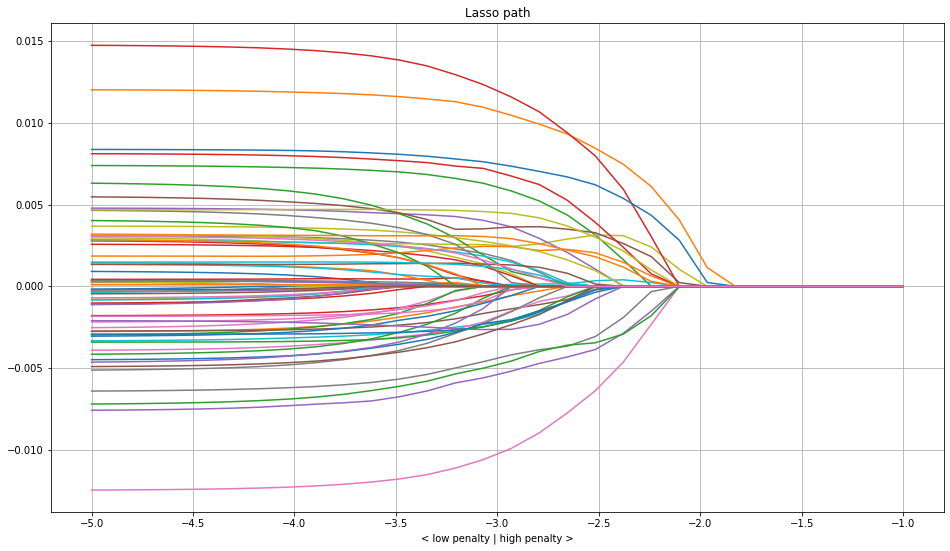

In [ ]:
fig, ax = plt.subplots(figsize=[16,9])
ax.plot(lasso_logalphas, lasso_coefs.squeeze().T)
ax.set_title('Lasso path')
ax.set_xlabel('< low penalty | high penalty >')
plt.grid()

## K-fold cross-validation

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" />

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold

In [ ]:
cv = KFold(n_splits=10)

In [ ]:
lassocv = LassoCV(fit_intercept=True, cv=cv, n_alphas=100)
result = lassocv.fit(df_features_rescaled, sr_targets)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


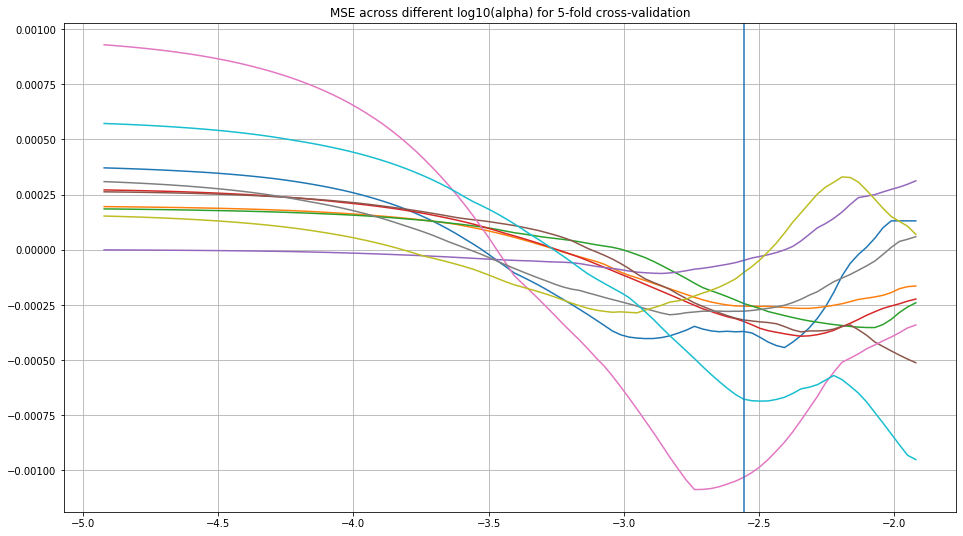

In [ ]:
fig = plt.figure(figsize=[16,9])
plt.plot(np.log10(result.alphas_), result.mse_path_ - result.mse_path_.mean(axis=0, keepdims=True))
plt.axvline(np.log10(result.alpha_))
plt.title('MSE across different log10(alpha) for 5-fold cross-validation')
plt.grid()

In [ ]:
sr_coef = pd.Series(lassocv.coef_, index=df_features.columns)
sr_coef[sr_coef != 0].sort_values()

aeavol          -0.006807
grltnoa         -0.004020
roavol          -0.003516
divi            -0.003295
pchdepr         -0.001067
secured         -0.000554
pctacc          -0.000420
convind         -0.000418
realestate      -0.000251
dy              -0.000203
hire            -0.000101
cfp_ia           0.000288
tb               0.000359
saleinv          0.001160
chpmia           0.001370
nincr            0.001939
operprof         0.002149
cfp              0.003076
chtx             0.003231
pchgm_pchsale    0.003366
mom36m           0.003547
sp               0.004391
ear              0.006368
rd_mve           0.008373
indmom           0.008701
dtype: float64

## Other types of cross-validation techniques

Different problems, data availability require different cross-validation methods. We discuss a few here. For a comprehensive overview, see [sklearn manual](https://scikit-learn.org/stable/modules/cross_validation.html)

### Leave One Out
```
fold 0   x . . . . . . . . .
fold 1   . x . . . . . . . .
 ...
fold N   . . . . . . . . . x
```
Pros: ?  
Cons: ?

### Stratified K-Fold
<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_009.png" />

Pros: ?  
Cons: ?

### Timeseries Split
<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png" />

Pros: ?  
Cons: ?


### hv-block Cross Validation
<img src="https://images.deepai.org/converted-papers/1910.08904/images/hv-block.png"/>

Pros: ?  
Cons: ?

### Group K-fold
<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_007.png">

Pros: ?  
Cons: ?

# Decision trees and random forests

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_tree_regression_001.png" />

We now explore decision trees and their generalization, random forests. Trees are very powerful but tend to overfit. Yesterday, we looked at how their recall and precision fared when allowing for `max_depth` to change.

Today we use the classification report to compare decision trees, random forests and support vector machines on **out-of-sample** performances.

For this we do the following for each model

1. Split the sample into training and testing
2. Pick hyperparameters using cross-validation in the training
3. Make predictions for the testing data

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

Splitting into training and testing

In [ ]:
X = df_features.values 
y = sr_targets.squeeze().values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=.2,
    shuffle=True,
    random_state=1,
)

## Decision tree

In [ ]:
mdl_tree = DecisionTreeRegressor()

In [ ]:
gscv_tree = GridSearchCV(
    estimator=mdl_tree,
    param_grid=dict(
        max_depth=np.arange(1,20),
    ),
    cv=KFold(n_splits=5),
)

In [ ]:
gscv_tree.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [ ]:
gscv_tree.cv_results_

{'mean_fit_time': array([0.00334015, 0.00450325, 0.00738707, 0.0085176 , 0.01127572,
        0.01239767, 0.01442986, 0.01650271, 0.0187108 , 0.01933517,
        0.02102017, 0.02389264, 0.02779827, 0.02553992, 0.02799335,
        0.02886801, 0.02989979, 0.03092895, 0.03633013]),
 'std_fit_time': array([1.30641913e-03, 7.28005578e-05, 1.47109006e-03, 1.87530822e-04,
        1.83263899e-03, 1.12552823e-04, 5.15531307e-04, 1.02904470e-03,
        2.32635007e-03, 2.22330897e-04, 2.10622109e-04, 1.25474811e-03,
        2.44813374e-03, 1.12885736e-04, 1.23726175e-03, 3.72439748e-04,
        3.31131853e-04, 2.18943176e-04, 4.78711102e-03]),
 'mean_score_time': array([0.00051012, 0.00044012, 0.00057154, 0.00052609, 0.0006104 ,
        0.00059614, 0.00060058, 0.00069532, 0.00056534, 0.00058575,
        0.0006588 , 0.00082364, 0.00063686, 0.00059876, 0.00070009,
        0.00064521, 0.00062647, 0.00060844, 0.00068102]),
 'std_score_time': array([1.71759670e-04, 3.70975019e-05, 1.51238991e-04, 3.74

In [ ]:
optm_tree = gscv_tree.best_estimator_

In [ ]:
optm_tree.max_depth

1

In [ ]:
nonzero = optm_tree.feature_importances_ != 0

In [ ]:
df_features.columns[nonzero]

Index(['rd_mve'], dtype='object')

In [ ]:
nonzero = optm_tree.feature_importances_ != 0

In [ ]:
y_test_pred = optm_tree.predict(X_test)
y_train_pred = optm_tree.predict(X_train)

mse_tree_test = mean_squared_error(y_test_pred, y_test)
mse_tree_train = mean_squared_error(y_train_pred, y_train)

In [ ]:
mse_tree_test

0.010776644326162902

In [ ]:
mse_tree_train

0.0004266635456715354

## Random Forest

<img src="https://upload.wikimedia.org/wikipedia/commons/7/76/Random_forest_diagram_complete.png" />

In [ ]:
mdl_forest = RandomForestRegressor(
    n_estimators=5
)

In [ ]:
gscv_forest = GridSearchCV(
    estimator=mdl_forest,
    param_grid=dict(
        max_depth=np.arange(1,20),
    ),
    cv=KFold(n_splits=10),
)

In [ ]:
gscv_forest.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestRegressor(n_estimators=5),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [ ]:
optm_forest = gscv_forest.best_estimator_

In [ ]:
optm_forest.n_estimators

5

In [ ]:
optm_forest.max_depth

2

In [ ]:
y_test_pred = optm_forest.predict(X_test)
y_train_pred = optm_forest.predict(X_train)
mse_forest_test = mean_squared_error(y_test_pred, y_test)
mse_forest_train = mean_squared_error(y_train_pred, y_train)

In [ ]:
mse_forest_test

0.002303053966116054

In [ ]:
mse_forest_train

0.0020266321979854054

## Support Vector Regression


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/7a/Svr_epsilons_demo.svg/2880px-Svr_epsilons_demo.svg.png" />

In [ ]:
mdl_svr = SVR()

In [ ]:
gscv_svr = GridSearchCV(
    estimator=mdl_svr,
    param_grid=dict(
        kernel=['linear','rbf'],
        C=np.linspace(.1,2,10),
    ),
    cv=KFold(n_splits=10),
)

In [ ]:
gscv_svr.fit(X_train, y_train)

In [ ]:
optm_svr = gscv_svr.best_estimator_

In [ ]:
y_test_pred = optm_svr.predict(X_test)
y_train_pred = optm_svr.predict(X_train)
mse_svr_test = mean_squared_error(y_test_pred, y_test)
mse_svr_train = mean_squared_error(y_train_pred, y_train)

In [ ]:
mse_svr_test

In [ ]:
mse_svr_train

## Comparison

In [ ]:
print('mse_tree_test   ', mse_tree_test)
print('mse_tree_train  ', mse_tree_train)
print('mse_forest_test ', mse_forest_test)
print('mse_forest_train', mse_forest_train)
print('mse_svr_test    ', mse_svr_test)
print('mse_svr_train   ', mse_svr_train)

mse_tree_test    0.010776644326162902
mse_tree_train   0.0004266635456715354
mse_forest_test  0.00420293388746303
mse_forest_train 0.00016371620315709757
mse_svr_test     0.0024538112517911727
mse_svr_train    0.0013664209555746501


# Clustering

We try to cluster firms based on their characteristics. Note that we do not use the returns here, as this is **unsupervised learning**. I.e. we are not interested in clustering such that we obtain better predictions. Instead, we want to best "summarize" the data for the "general reader". 

See PCA and Dynamic factor models.

Full documentation here [sklearn manual](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)

In [ ]:
x = 'aeavol'
y = 'rd'

In [ ]:
df_X = np.sqrt(df_features.loc[:,[x,y]])
df_X = df_X.dropna()

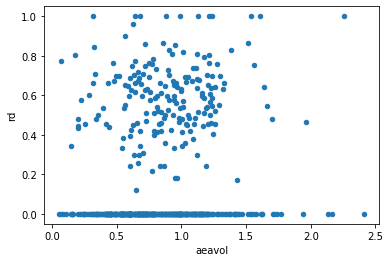

In [ ]:
df_X.plot.scatter(x,y)

In [ ]:
n_clusters = 3
colors = ['red','blue','green']

## KMeans clustering

In [ ]:
from sklearn.cluster import KMeans

We first estimate the full model using `KMeans`

In [ ]:
kmeans = KMeans(
    n_clusters=n_clusters, 
    random_state=0,
).fit(df_X)

Results are the cluster memberships of each company

In [ ]:
sr_clusters = pd.Series(kmeans.labels_, index=df_X.index, name='clusters')
sr_clusters

permno
10080    0
10087    0
10100    0
10149    1
10200    2
        ..
86574    1
86685    1
86727    0
86729    2
86739    2
Name: clusters, Length: 635, dtype: int32

In [ ]:
sr_clusters.value_counts()

1    323
2    161
0    151
Name: clusters, dtype: int64

In [ ]:
df_X.join(sr_clusters).groupby('clusters').mean()

,aeavol,rd
clusters,,
0,1.180454,0.019629
1,0.575519,0.025682
2,0.921984,0.639050


In [ ]:
df_X_clusters = df_X.join(sr_clusters).groupby('clusters')
centroids = df_X_clusters.mean().values

In [ ]:
# store for comparison
sr_clusters_km = sr_clusters.copy()

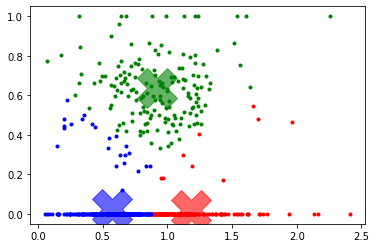

In [ ]:
for permno, (x1, x2) in df_X.iterrows():
  cluster = sr_clusters[permno]
  color = colors[cluster]
  plt.plot(
    x1, x2,
    color=color,
    marker='o', markersize=3, lw=0
  )
for i, (x1, x2) in enumerate(centroids):
  plt.plot(x1, x2, color=colors[i], marker='X', markersize=40, alpha=.6)

## AgglomerativeClustering

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_agglomerative_dendrogram_001.png">

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
agg = AgglomerativeClustering(
    n_clusters=n_clusters
).fit(df_X)

sr_clusters = pd.Series(agg.labels_, index=df_X.index, name='clusters')
df_X_clusters = df_X.join(sr_clusters).groupby('clusters')
centers = df_X_clusters.mean().values

In [ ]:
# store for comparison
sr_clusters_agg = sr_clusters.copy()

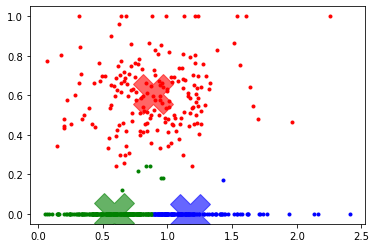

In [ ]:
for permno, (x1, x2) in df_X.iterrows():
  cluster = sr_clusters[permno]
  color = colors[cluster]
  plt.plot(
    x1, x2,
    color=color,
    marker='o', markersize=3, lw=0
  )
for i, (x1, x2) in enumerate(centers):
  plt.plot(x1, x2, color=colors[i], marker='X', markersize=40, alpha=.6)

## How to evaluate clustering performance?

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:

help(silhouette_score)

Help on function silhouette_score in module sklearn.metrics.cluster._unsupervised:

silhouette_score(X, labels, *, metric='euclidean', sample_size=None, random_state=None, **kwds)
    Compute the mean Silhouette Coefficient of all samples.
    
    The Silhouette Coefficient is calculated using the mean intra-cluster
    distance (``a``) and the mean nearest-cluster distance (``b``) for each
    sample.  The Silhouette Coefficient for a sample is ``(b - a) / max(a,
    b)``.  To clarify, ``b`` is the distance between a sample and the nearest
    cluster that the sample is not a part of.
    Note that Silhouette Coefficient is only defined if number of labels
    is ``2 <= n_labels <= n_samples - 1``.
    
    This function returns the mean Silhouette Coefficient over all samples.
    To obtain the values for each sample, use :func:`silhouette_samples`.
    
    The best value is 1 and the worst value is -1. Values near 0 indicate
    overlapping clusters. Negative values generally indi

## KMeans silhouette

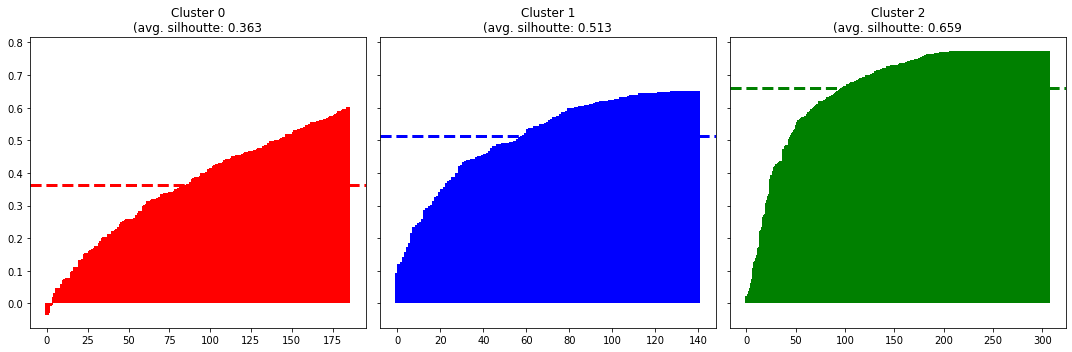

In [ ]:
fig, axes = plt.subplots(1, n_clusters, sharey=True, figsize=[15,5])

silhouette_values = silhouette_samples(df_X, sr_clusters_km)

for cluster in sr_clusters.unique():
  ax = axes[cluster]
  color = colors[cluster]
  sils = silhouette_values[sr_clusters == cluster]
  sils = sorted(sils)
  ax.bar(range(len(sils)), sils, color=color, width=2)

  sils_avg = np.mean(sils)
  ax.axhline(sils_avg, lw=3, ls='--', color=color)
  ax.set_title(f'Cluster {cluster}\n(avg. silhoutte: {sils_avg:.3f}')

fig.tight_layout()

## Agglomerative clustering

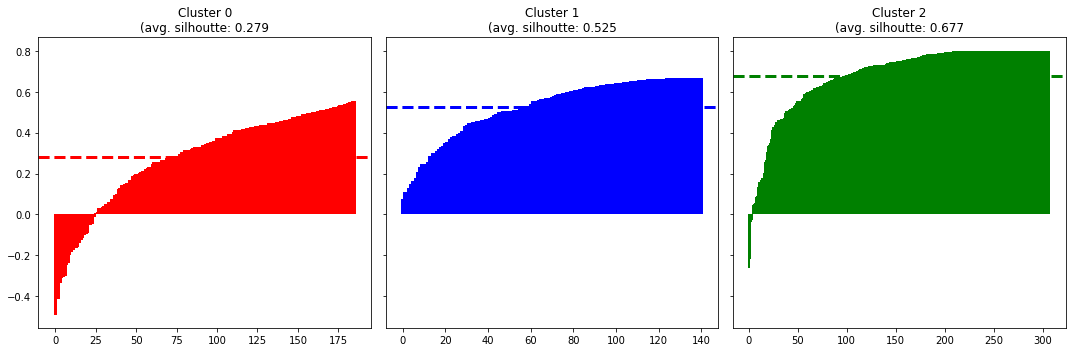

In [ ]:
fig, axes = plt.subplots(1, n_clusters, sharey=True, figsize=[15,5])

silhouette_values = silhouette_samples(df_X, sr_clusters_agg)

for cluster in sr_clusters.unique():
  ax = axes[cluster]
  color = colors[cluster]
  sils = silhouette_values[sr_clusters == cluster]
  sils = sorted(sils)
  ax.bar(range(len(sils)), sils, color=color, width=2)

  sils_avg = np.mean(sils)
  ax.axhline(sils_avg, lw=3, ls='--', color=color)
  ax.set_title(f'Cluster {cluster}\n(avg. silhoutte: {sils_avg:.3f}')

fig.tight_layout()